##### Colab-specific section (convert to code if needed)
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!unlink "/content/coopmotion"
!ln -s "/gdrive/My Drive/coopmotion/" "/content/coopmotion"
!rm -r "/content/coopmotion/dataset (1)" "/content/coopmotion/dataset" "/content/coopmotion/models"

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
sys.path.append('coopmotion/src') # COLAB
from matplotlib import pyplot as plt
from task.fancy import animate_with_targets, plot_trace
import numpy as np
import torch
import time

# Learning

In [53]:
from task.dataset import *
from task.square import *
controller = proportional

In [54]:
task = static_evenly_spread_task(4, holonomic=True)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)

In [55]:
number_of_samples = 100
eps = 0.01
train_dataset = central_dataset(
    generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))
test_dataset = central_dataset(
    generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))


x (3728, 8)	y (3728, 8)



x (3767, 8)	y (3767, 8)


# Centralized Network

In [56]:
from keras_network import CentralizedNet
net = CentralizedNet(4, run.task.holonomic)
history = net.train(epochs=100, train_dataset=train_dataset, test_dataset=test_dataset)

mean_squared_error: 0.00
mean_absolute_error: 0.01
mean_squared_error: 0.00
accuracy: 0.70


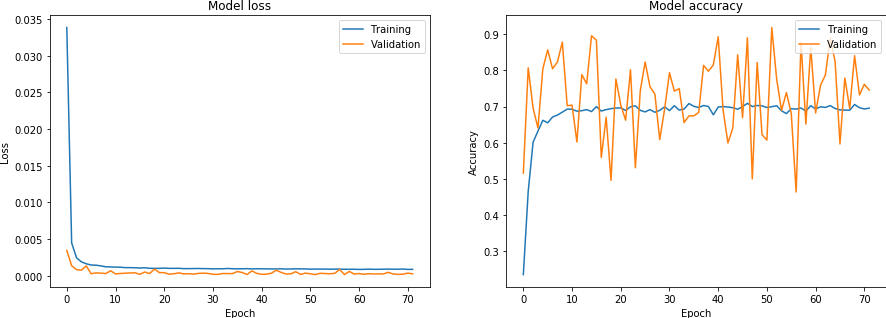

Saved in images/training/eps=0.01_n=100_net=CentralizedNet_t=holo-StaticPositionTask.png


<Figure size 432x288 with 0 Axes>

In [57]:
from task.fancy import training_plot
training_plot(history, context=globals())

Saved in images/trace/eps=0.01_n=100_net=CentralizedNet_t=holo-StaticPositionTask.png


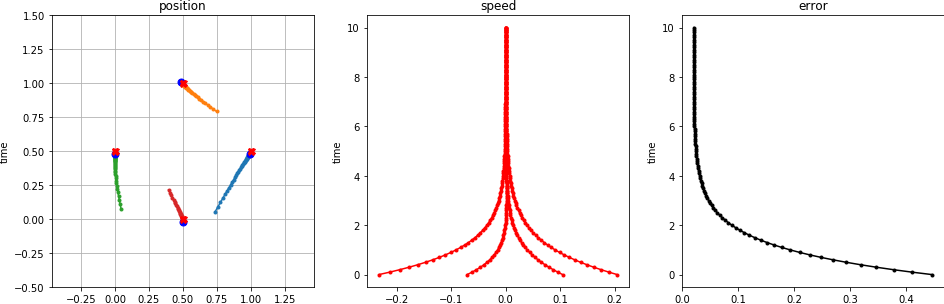

In [58]:
from task import Run
from task.square import sense
net_controller = net.controller()
net_run = Run(task, sensor=run.sensor, dt=0.1, controller=net_controller)
trace = net_run(T=10, epsilon=eps)
plot_trace(trace, task, context=globals())

In [59]:
animate_with_targets(trace, sensor=net_run.sensor, context=globals())

(101, 4, 2)
Saved in videos/eps=0.01_n=100_net=CentralizedNet_t=holo-StaticPositionTask.mp4


### How well are we controlling the agents?

In [60]:
from task.dataset import generate_sequential_dataset
exact_traces = generate_sequential_dataset(run, number=100, duration=10, epsilon=0.01)
net_traces = generate_sequential_dataset(net_run, number=100, duration=10, epsilon=0.01)
from task import prepare
exact_traces = [prepare(t, padding=True, steps=50) for t in exact_traces]
net_traces = [prepare(t, padding=True, steps=50) for t in net_traces]
time = exact_traces[0].time
exact_error = np.array([t.error for t in exact_traces])
net_error = np.array([t.error for t in net_traces])

Saved in images/error/eps=0.01_n=100_net=CentralizedNet_t=holo-StaticPositionTask.png


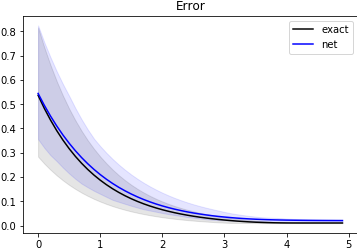

In [61]:
from task.fancy import plot_error
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, context=globals(), color='blue', label='net')

## Distributed Network

In [146]:
from task.square import SquareRun, adaptive_evenly_spread_task, sense
from task.dataset import distributed_dataset

In [147]:
task = adaptive_evenly_spread_task(4, holonomic=False, radius=None)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)

In [148]:
number_of_samples = 1000
eps = 0.01
d_train_dataset = distributed_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))
d_test_dataset = distributed_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))
#d_train_dataset = distributed_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))
#d_test_dataset = distributed_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))

(373520, 6) (373520, 2)


(373516, 6) (373516, 2)


In [ ]:
from keras_network import DistributedNet
d_net = DistributedNet(run=run)
history = d_net.train(epochs=100, train_dataset=d_train_dataset, test_dataset=d_test_dataset);

Train on 298816 samples, validate on 74704 samples
Epoch 1/100
298816/298816 [==============================] - 11s 35us/sample - loss: 0.1263 - mean_absolute_error: 0.1822 - mean_squared_error: 0.1263 - acc: 0.6929 - val_loss: 0.1244 - val_mean_absolute_error: 0.1734 - val_mean_squared_error: 0.1244 - val_acc: 0.7208
Epoch 2/100
298816/298816 [==============================] - 10s 35us/sample - loss: 0.1251 - mean_absolute_error: 0.1791 - mean_squared_error: 0.1251 - acc: 0.7013 - val_loss: 0.1240 - val_mean_absolute_error: 0.1815 - val_mean_squared_error: 0.1240 - val_acc: 0.6723
Epoch 3/100
298816/298816 [==============================] - 11s 36us/sample - loss: 0.1251 - mean_absolute_error: 0.1792 - mean_squared_error: 0.1251 - acc: 0.6998 - val_loss: 0.1241 - val_mean_absolute_error: 0.1826 - val_mean_squared_error: 0.1241 - val_acc: 0.6889
Epoch 4/100
298816/298816 [==============================] - 11s 36us/sample - loss: 0.1251 - mean_absolute_error: 0.1792 - mean_squared_error

298816/298816 [==============================] - 11s 36us/sample - loss: 0.1251 - mean_absolute_error: 0.1791 - mean_squared_error: 0.1251 - acc: 0.7007 - val_loss: 0.1240 - val_mean_absolute_error: 0.1817 - val_mean_squared_error: 0.1240 - val_acc: 0.7068
Epoch 32/100
298816/298816 [==============================] - 11s 35us/sample - loss: 0.1250 - mean_absolute_error: 0.1791 - mean_squared_error: 0.1250 - acc: 0.7019 - val_loss: 0.1243 - val_mean_absolute_error: 0.1857 - val_mean_squared_error: 0.1243 - val_acc: 0.6482
Epoch 33/100
298816/298816 [==============================] - 11s 36us/sample - loss: 0.1251 - mean_absolute_error: 0.1792 - mean_squared_error: 0.1251 - acc: 0.7017 - val_loss: 0.1241 - val_mean_absolute_error: 0.1842 - val_mean_squared_error: 0.1241 - val_acc: 0.6647
Epoch 34/100
298816/298816 [==============================] - 11s 36us/sample - loss: 0.1251 - mean_absolute_error: 0.1792 - mean_squared_error: 0.1251 - acc: 0.6998 - val_loss: 0.1242 - val_mean_absolut

In [ ]:
d_net_controller = d_net.controller()
d_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=d_net_controller)
trace = d_net_run(T=5, epsilon=0.01)
plot_trace(trace, task)

In [ ]:
animate_with_targets(trace, sensor=net_run.sensor)

In [ ]:
d_net_traces = generate_sequential_dataset(d_net_run, number=100, duration=10, epsilon=0.01)
d_net_traces = [prepare(t, padding=True, steps=50) for t in d_net_traces]
d_net_error = np.array([t.error for t in d_net_traces])

In [ ]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plt.legend()
plt.title('Error');

## Distributed Communicating Network

In [ ]:
from task.dataset import sequence_dataset
from task.square import smart_static_evenly_spread_task, sense_in_range, SegmentRun, proportional, static_zipf_task

In [ ]:
number_of_samples = 10
run = SegmentRun(smart_static_evenly_spread_task(4), controller=controller, sensor=sense_in_range(0.8), dt=0.1)
train_traces = generate_sequential_dataset(run=run, number=number_of_samples)
test_traces = generate_sequential_dataset(run=run, number=number_of_samples)

In [ ]:
c_train_dataset = sequence_dataset(train_traces, steps=2)
c_test_dataset = sequence_dataset(test_traces, steps=2)
c_train_dataset[50]

In [ ]:
from com_network import ComNet

In [ ]:
c_net = ComNet(N=N, broadcast=2)
c_training_loss, c_testing_loss = [], []

In [ ]:
train_net(epochs=100, net=c_net, train_dataset=c_train_dataset, test_dataset=c_test_dataset, batch_size=100, 
          training_loss=c_training_loss, testing_loss=c_testing_loss);

In [ ]:
plt.title('Loss')
plt.semilogy(c_training_loss, label='training')
plt.semilogy(c_testing_loss, label='testing')
plt.xlabel('epoch')
plt.legend()

In [ ]:
c_net_controller = c_net.controller()
c_net_run = Run(task, dynamic=dynamic(dt=0.1), sensor=run.sensor, dt=0.1, controller=c_net_controller)

In [ ]:
trace = c_net_run(T=5)
plot_trace(trace,task)

In [ ]:
animate_with_targets(trace, sensor=net_run.sensor)

In [ ]:
plt.plot(trace.control[:,:,0], trace.communication[:,0,:], '.')

In [ ]:
c_net_traces = generate_sequential_dataset(c_net_run, number=100, duration=5, epsilon=0.01)

In [ ]:
c_net_traces = [prepare(t, padding=True, steps=50) for t in c_net_traces]

In [ ]:
c_net_error = np.array([t.error for t in c_net_traces])

In [ ]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plot_error(time, c_net_error, color='orange', label='c_net')
plt.legend()
plt.title('Error');